In [28]:
import numpy as np
from distutils.command.install import install
import pandas as pd
import datetime 
from datetime import timedelta
import matplotlib.pyplot as plt
import warnings
import  scipy.signal.signaltools
import seaborn as sns
from darts.models import Theta, FourTheta
from darts.metrics import mape
from darts import TimeSeries
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts.metrics import mape as mape_theta,mae as mae_theta,rmse as rmse_theta,mse as mse_theta
from darts.models import TBATS
from darts.metrics import mape

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered
import statsmodels.api as sm

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.ets import AutoETS
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import nbconvert
from turtle import color
from darts.models import Theta, FourTheta

## Analizar los datos de MATLAB, entre otros análisis, se debe graficar laserie, estudiar la estacionalidad y la estacionariedad.

In [2]:
patron_JC= 'C:/Users/javoc/OneDrive/Escritorio/MASTER/AnalisisPredictivo/Practica3/StackOverflow.csv'
patrón_YC= r'C:\Users\Usuario\Desktop\universidad\Analisis predictivo\StackOverflow.csv'
data=pd.read_csv(patron_JC)
data=pd.DataFrame(data[['month','matlab']])
data['month'] = pd.to_datetime(data['month'],format='%y-%b')
data.rename(columns = {'month':'fecha'}, inplace = True)
data=data.set_index(data['fecha'])
data=data.drop(['fecha'], axis=1)
data.index = pd.PeriodIndex(data.index, freq="M")

In [3]:
#data.isna().sum()

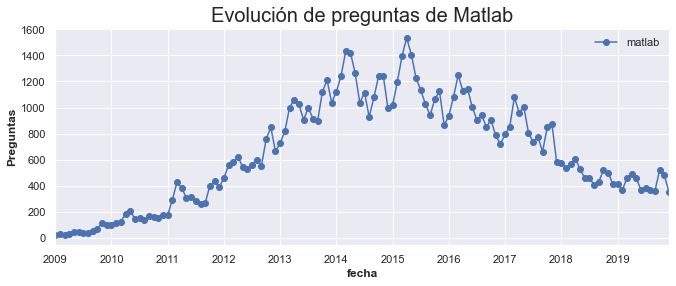

In [4]:
sns.set(rc={'figure.figsize':(11, 4)})
ax = data.plot(marker='o', linestyle='-')
ax.set_ylabel('Preguntas')
ax.set_title('Evolución de preguntas de Matlab',fontsize=20);

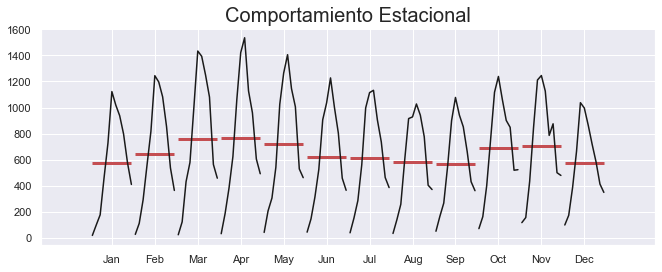

In [5]:
ax = plt.gca()
sm.graphics.tsa.month_plot(data['matlab'],ax=ax)
ax.set_title('Comportamiento Estacional',fontsize=20);

##  Se debe separa la muestra en tres partes entrenamiento, validación(12meses) y test (6 meses). Cuando no sea necesaria la validación la muestra de test debe ser de 6 meses.


In [6]:
train_completo, test = temporal_train_test_split(y = data['matlab'], test_size=6)
train_parcial, validation = temporal_train_test_split(y = train_completo, test_size=12)

print('train completo', train_completo.shape)
print('test',test.shape)
print('train parcial',train_parcial.shape)
print('validation',validation.shape)

train completo (126,)
test (6,)
train parcial (114,)
validation (12,)


## Debemos buscar el mejor modelo predictivo entre los siguientes:

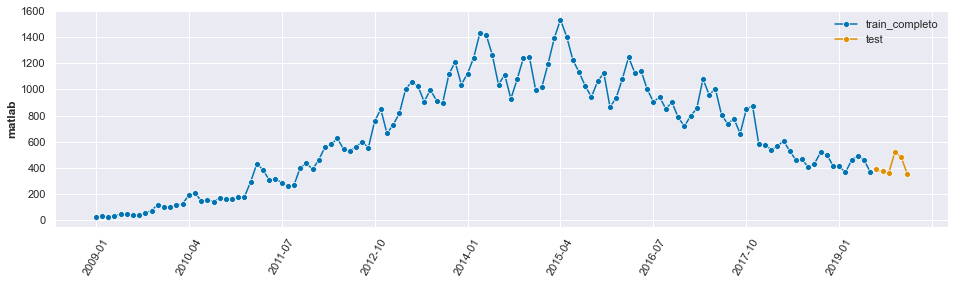

In [7]:
plot_series(train_completo, test, labels=["train_completo", "test"]);
plt.xticks(rotation=60)
warnings.filterwarnings("ignore")

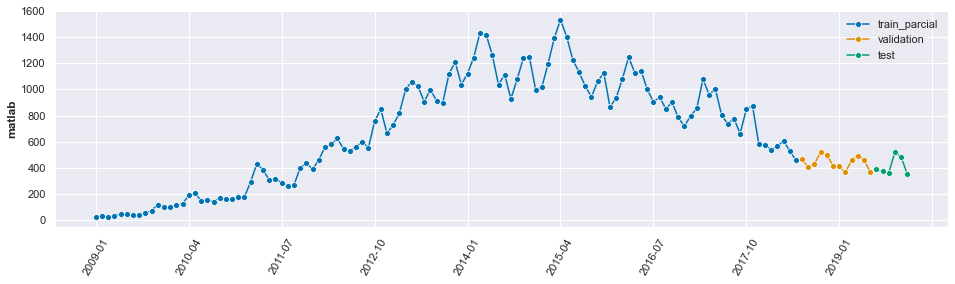

In [8]:
plot_series(train_parcial, validation, test, labels=["train_parcial", "validation", "test"]);
plt.xticks(rotation=60)
warnings.filterwarnings("ignore")

### ETS

In [9]:
fh = np.arange(1, 7)
modelo_ETS = AutoETS(auto=True, sp=12, n_jobs=-1)
modelo_ETS.fit(train_completo)

AutoETS(auto=True, n_jobs=-1, sp=12)

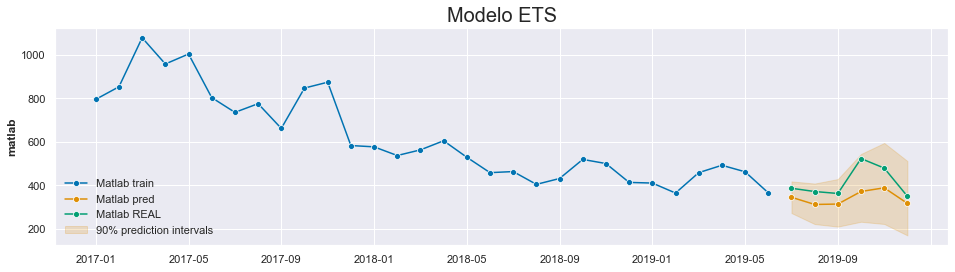

In [10]:
ets_pred = modelo_ETS.predict(fh)
ets_pred_ints = modelo_ETS.predict_interval(fh, coverage=0.9)
fig, ax = plot_series(train_completo["2017-01":], ets_pred,test, labels=["Matlab train", "Matlab pred", "Matlab REAL"])
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    ets_pred_ints[('Coverage', 0.9, 'lower')],
    ets_pred_ints[('Coverage', 0.9, 'upper')],
    alpha=0.2,
    color=ax.get_lines()[-2].get_c(),
    label=f"90% prediction intervals",
)
ax.legend(loc='lower left')
plt.title("Modelo ETS",fontsize=20);

In [11]:
mse=MeanSquaredError()
rmse = MeanSquaredError(square_root=True)

MAPE_ETS = mean_absolute_percentage_error(test, ets_pred[0:6])
MSE_ETS = mse(test, ets_pred[0:6])
RMSE_ETS = rmse(test, ets_pred[0:6])

lista_ETS = [MAPE_ETS,MSE_ETS,RMSE_ETS]

In [12]:
#modelo tipo multiplicativo aditivo multiplicativo
#AIC de 1417,907
#BIC de 1468.960
#HQIC de 1438.648

### ARIMA con ambas transformaciones

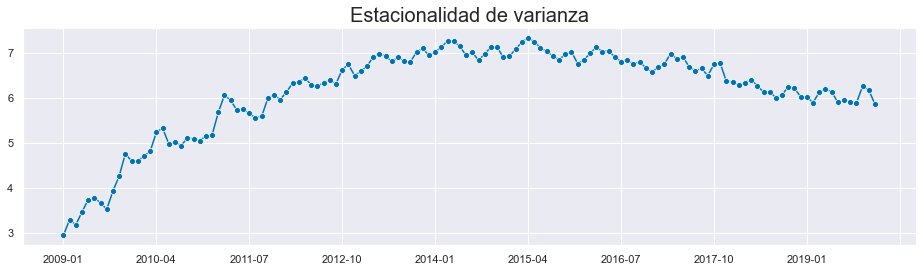

In [13]:
data_log=pd.DataFrame(LogTransformer().fit_transform(data['matlab']))
plot_series(data_log)
difference_log = data_log.diff(axis=0).dropna()
plt.title("Estacionalidad de varianza",fontsize=20);

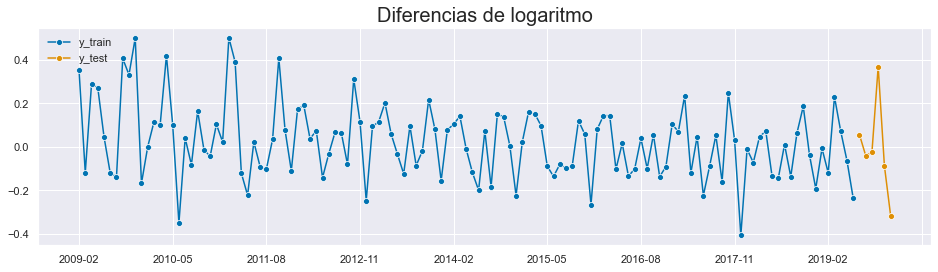

In [14]:
log_y_train, log_y_test = temporal_train_test_split(y =difference_log, test_size=6)
fh_arima = np.arange(1, 7)
plot_series(log_y_train, log_y_test, labels=["y_train", "y_test"])
plt.title("Diferencias de logaritmo",fontsize=20);

In [15]:
# AIC de 1454.705
# BIC de 1466.019
# HQIC de 1459.301

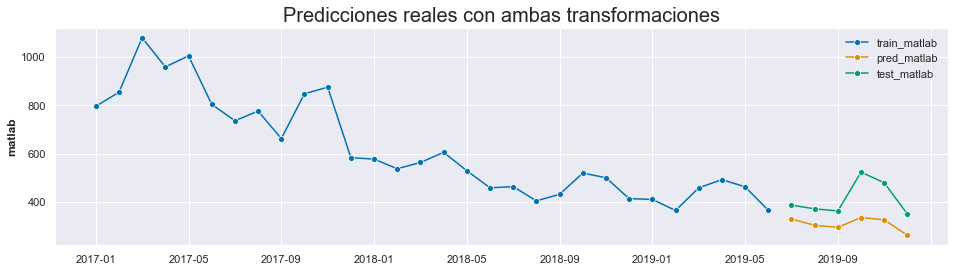

In [16]:
forecaster = AutoARIMA(sp=12,suppress_warnings=True)
forecaster.fit(log_y_train)
log_y_pred_arima = forecaster.predict(fh_arima)
plot_series(train_completo["2017-01":], np.exp(log_y_pred_arima[0].cumsum()+5.899897),test, labels=["train_matlab", "pred_matlab", "test_matlab"])
plt.title("Predicciones reales con ambas transformaciones",fontsize=20);

### (EXTRA) ARIMA con transformación en la media

In [17]:
diferencia=data.diff(axis=0).dropna()

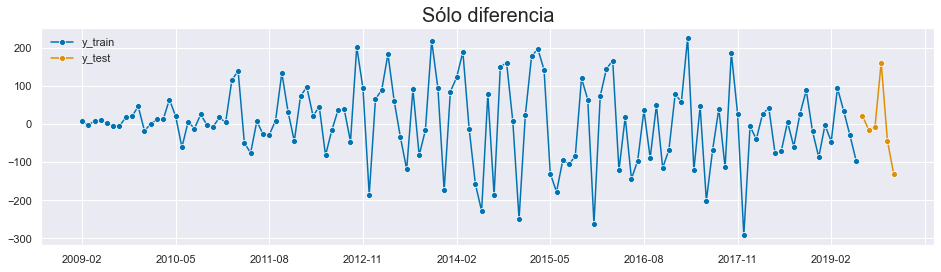

In [18]:
diferencia_y_train, diferencia_y_test = temporal_train_test_split(y =diferencia, test_size=6)
fh_arima_diferencia = np.arange(1, 7)
plot_series(diferencia_y_train, diferencia_y_test, labels=["y_train", "y_test"])
plt.title("Sólo diferencia",fontsize=20);

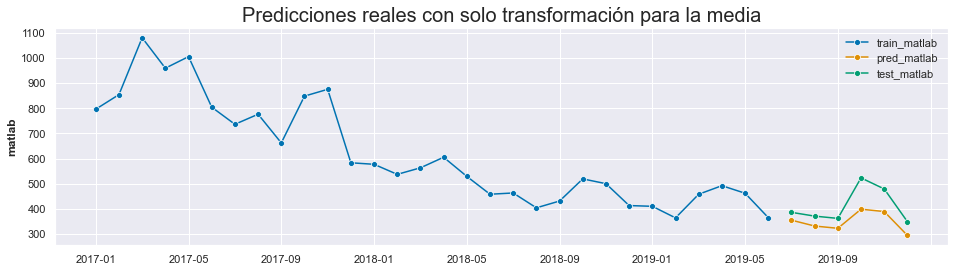

In [19]:
forecaster.fit(diferencia_y_train)
diferencia_y_pred_arima = forecaster.predict(fh_arima_diferencia)
plot_series(train_completo["2017-01":],diferencia_y_pred_arima.cumsum()+train_completo['2019-06'],test, labels=["train_matlab", "pred_matlab", "test_matlab"])
plt.title("Predicciones reales con solo transformación para la media",fontsize=20);

In [20]:
MAPE_ARIMA_ambas = mean_absolute_percentage_error(test, np.exp(log_y_pred_arima[0].cumsum()+5.899897)[0:6])
MSE_ARIMA_ambas = mse(test, np.exp(log_y_pred_arima[0].cumsum()+5.899897)[0:6])
RMSE_ARIMA_ambas = rmse(test, np.exp(log_y_pred_arima[0].cumsum()+5.899897)[0:6])
lista_ARIMA_ambas = [MAPE_ARIMA_ambas,MSE_ARIMA_ambas,RMSE_ARIMA_ambas]

MAPE_ARIMA_diferencia = mean_absolute_percentage_error(test, (diferencia_y_pred_arima['matlab'].cumsum()+train_completo['2019-06'])[0:6])
MSE_ARIMA_diferencia = mse(test, (diferencia_y_pred_arima['matlab'].cumsum()+train_completo['2019-06'])[0:6])
RMSE_ARIMA_diferencia = rmse(test, (diferencia_y_pred_arima['matlab'].cumsum()+train_completo['2019-06'])[0:6])
lista_ARIMA_diferencia = [MAPE_ARIMA_diferencia,MSE_ARIMA_diferencia,RMSE_ARIMA_diferencia]

### 4Theta

In [21]:
train_parcial_df=pd.DataFrame(train_parcial)
train_parcial_df=train_parcial_df.reset_index()
train_parcial_df.rename(columns = {'index':'fecha'}, inplace = True)
train_parcial_df['fecha'] = train_parcial_df['fecha'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d')
train_parcial_df = train_parcial_df.set_index('fecha')
train_parcial_df.index  = pd.to_datetime(train_parcial_df.index)

train_completo_df=pd.DataFrame(train_completo)
train_completo_df=train_completo_df.reset_index()
train_completo_df.rename(columns = {'index':'fecha'}, inplace = True)
train_completo_df['fecha'] = train_completo_df['fecha'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d')
train_completo_df = train_completo_df.set_index('fecha')
train_completo_df.index  = pd.to_datetime(train_completo_df.index)

val_ts_df=pd.DataFrame(validation)
val_ts_df=val_ts_df.reset_index()
val_ts_df.rename(columns = {'index':'fecha'}, inplace = True)
val_ts_df['fecha'] = val_ts_df['fecha'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d')
val_ts_df = val_ts_df.set_index('fecha')
val_ts_df.index  = pd.to_datetime(val_ts_df.index)

test_ts_df=pd.DataFrame(test)
test_ts_df=test_ts_df.reset_index()
test_ts_df.rename(columns = {'index':'fecha'}, inplace = True)
test_ts_df['fecha'] = test_ts_df['fecha'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d')
test_ts_df = test_ts_df.set_index('fecha')
test_ts_df.index  = pd.to_datetime(test_ts_df.index)

In [22]:
train_parcial_ts = TimeSeries.from_dataframe(train_parcial_df)
val_ts = TimeSeries.from_dataframe(val_ts_df)
test_ts = TimeSeries.from_dataframe(test_ts_df)
train_completo_ts=TimeSeries.from_dataframe(train_completo_df)

In [23]:
theta_grid = {
    'theta':2- np.linspace(-10, 10, 10),
    'model_mode': [ModelMode.ADDITIVE,ModelMode.MULTIPLICATIVE],
    'season_mode': [SeasonalityMode.MULTIPLICATIVE,SeasonalityMode.ADDITIVE],
    'trend_mode': [TrendMode.EXPONENTIAL,TrendMode.LINEAR]
}

best_grid_model=FourTheta.gridsearch(parameters=theta_grid,
                                series=train_parcial_ts,
                                forecast_horizon=12,
                                start=0.5,
                                last_points_only=False,
                                metric=mape,
                                reduction=np.mean,
                                verbose=False,
                                n_jobs=-1)

best_grid_model

(<darts.models.forecasting.theta.FourTheta at 0x208af0fbe20>,
 {'theta': 0.8888888888888893,
  'model_mode': <ModelMode.ADDITIVE: 'additive'>,
  'season_mode': <SeasonalityMode.ADDITIVE: 'additive'>,
  'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>},
 18.713270856289732)

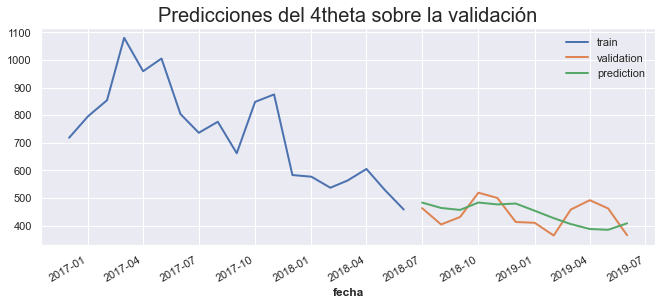

In [24]:
theta=FourTheta(theta=best_grid_model[1]['theta'],
                 model_mode=ModelMode.ADDITIVE,
                 season_mode=SeasonalityMode.ADDITIVE,
                 trend_mode=TrendMode.EXPONENTIAL
                 )
theta.fit(train_parcial_ts)
pred_modelo = theta.predict(len(val_ts))

train_parcial_ts[95:].plot(label="train")
val_ts.plot(label="validation")
pred_modelo.plot(label="prediction")
plt.title("Predicciones del 4theta sobre la validación",fontsize=20);

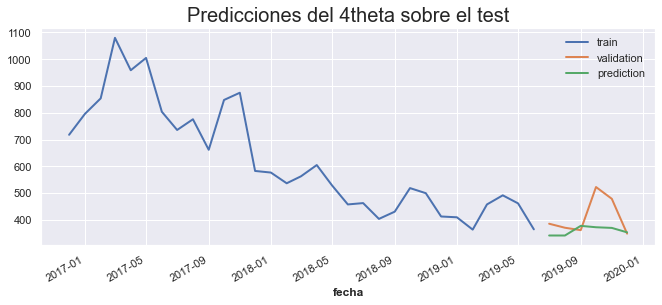

In [25]:
theta.fit(train_completo_ts)
pred_modelo = theta.predict(len(test_ts))

train_completo_ts[95:].plot(label="train")
test_ts.plot(label="test")
pred_modelo.plot(label="prediction")
plt.title("Predicciones del 4theta sobre el test",fontsize=20);

In [43]:
MAPE_theta=mape_theta(test_ts, pred_modelo)/100
MSE_THETA=mse_theta(test_ts, pred_modelo)
RMSE_THETA=rmse_theta(test_ts, pred_modelo)

lista_THETA = [MAPE_theta,MSE_THETA,RMSE_THETA]

### TBATS

In [31]:
Data_fortheta=pd.read_csv(patron_JC)
Data_fortheta['month']=pd.to_datetime(Data_fortheta['month'], format="%y-%b")

train_fortheta=Data_fortheta[:-18]
test_fortheta=Data_fortheta[-6:]
val_fortheta=Data_fortheta[-18:-6]
train_fortheta_completo=Data_fortheta[:-6]

Series=TimeSeries.from_dataframe(Data_fortheta[:-6], 'month', 'matlab')
train_fortheta_use=TimeSeries.from_dataframe(train_fortheta, 'month', 'matlab')
train_fortheta_completo_use=TimeSeries.from_dataframe(train_fortheta_completo, 'month', 'matlab')
test_fortheta_use=TimeSeries.from_dataframe(test_fortheta, 'month', 'matlab')
val_fortheta_use=TimeSeries.from_dataframe(val_fortheta, 'month', 'matlab')

In [34]:
modelo_tbats =TBATS(
use_box_cox=None,
box_cox_bounds=(0, 1),
use_trend=None,
use_damped_trend=None,
seasonal_periods=(12,1),
use_arma_errors=True,
show_warnings=False,
multiprocessing_start_method='spawn',
random_state=0)
modelo_tbats.fit(train_fortheta_use)
forecast = modelo_tbats.predict(len(val_fortheta_use))

model (T)BATS obtains MAPE: 18.83%


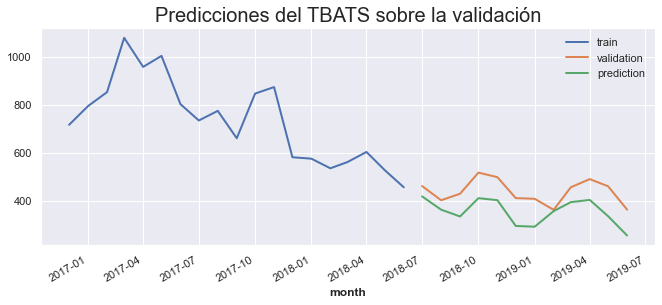

In [37]:
train_fortheta_use[95:].plot(label="train")
val_fortheta_use.plot(label="validation")
forecast.plot(label="prediction")
plt.title("Predicciones del TBATS sobre la validación",fontsize=20);

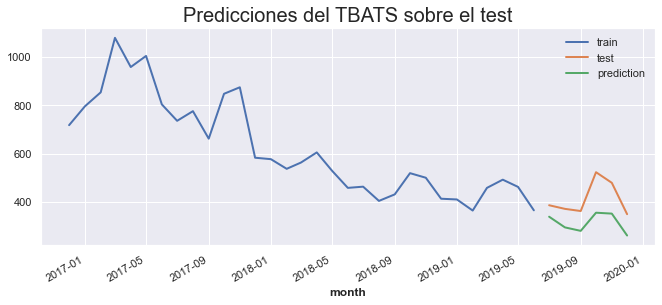

In [42]:
modelo_tbats.fit(train_fortheta_completo_use)
forecast = modelo_tbats.predict(len(test_fortheta_use))

train_fortheta_completo_use[95:].plot(label="train")
test_fortheta_use.plot(label="test")
forecast.plot(label="prediction")
plt.title("Predicciones del TBATS sobre el test",fontsize=20);

In [ ]:
print("model {} obtains MAPE: {:.2f}%".format(modelo_tbats, mape(val_fortheta_use, forecast)))
print("MAPE = {:.2f}%".format(mape(historical_fcast_tbats, Series)))

In [44]:
MAPE_tbats=mape_theta(test_fortheta_use, forecast)/100
MSE_tbats=mse_theta(test_fortheta_use, forecast)
RMSE_tbats=rmse_theta(test_fortheta_use, forecast)

lista_tbats = [MAPE_tbats,MSE_tbats,RMSE_tbats]

## Una vez seleccionado el modelo se debe realizar una predicción de 12 meses fuera de la muestra


In [45]:
tabla_errores=pd.DataFrame()
tabla_errores['Métrica'] = ['MAPE','MSE','RMSE']
tabla_errores=tabla_errores.set_index(tabla_errores['Métrica'])
tabla_errores=tabla_errores.drop(['Métrica'], axis=1)
tabla_errores['ETS'] = lista_ETS
tabla_errores['ARIMA media/var'] = lista_ARIMA_ambas
tabla_errores['ARIMA media']=lista_ARIMA_diferencia
tabla_errores['4Theta']=lista_THETA
tabla_errores['Tbats']=lista_tbats
tabla_errores

,ETS,ARIMA media/var,ARIMA media,4Theta,Tbats
Métrica,,,,,
MAPE,0.162788,0.242114,0.146284,0.127333,0.233071
MSE,6673.546148,13210.286007,5102.012717,6233.772959,11208.344134
RMSE,81.691775,114.936008,71.428375,78.954246,105.869467


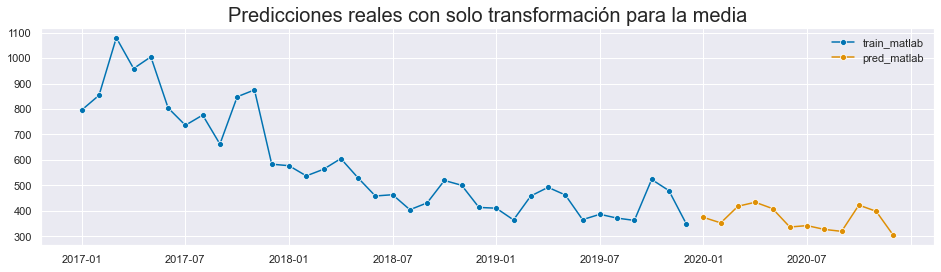

In [47]:
forecaster = AutoARIMA(sp=12,suppress_warnings=True)
forecaster.fit(diferencia)

fh_total = np.arange(1, 13)
diferencia_total = forecaster.predict(fh_total)
plot_series(data["2017-01":],diferencia_total.cumsum()+train_completo['2019-06'], labels=["Realidad", "Predicción futura"])
plt.title("Predicciones de los 12 meses fuera de la muestra",fontsize=20);

In [ ]:
#MPAE mas alto porque el 4theta hace una casí una linea recta y suvaiza mucho las predicciones.
# sin embargo el arima sigue muy bien la tendencia aunque empieza desde mas abajo la predicción y por eso el MAPE es mas grande